# Lab14: NumPy + OpenCV

## Lab Goals

**Demo1**: Change crying emoji into smiley emoji

**Demo2**: Do histogram equalization on provided image

If you are not using docker containers or devcontainers
```bash
    pip install numpy opencv-python matplotlib  
```

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_img(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

## TA demo

real-time line detection

In [2]:
from IPython.display import display, clear_output
import time
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    eroded = cv2.erode(thresh, None, iterations=2)
    dilated = cv2.dilate(eroded, None, iterations=2)
    edges = cv2.Canny(dilated, 100, 200)
    return edges

def apply_roi_mask(edges, width, height):
    vertices = np.array([[
        (0, height), (width//20, 2*height//6),
        (19*width//20, 2*height//6), (width, height)
    ]], dtype=np.int32)

    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, 255)
    return cv2.bitwise_and(edges, mask)

def classify_lines(lines, width):
    left_lines, right_lines = [], []
    middle_x = width / 2

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 == x2:
            continue
        slope = (y2-y1) / (x2 - x1)
        if 0.35 < slope < 0.85 and x1 > middle_x/2:
            right_lines.append(line)
        elif -0.85 < slope < -0.35 and x1 < 3*width/4:
            left_lines.append(line)
    return left_lines, right_lines

def calculate_triangle_area(vertices):
    x1, y1 = vertices[0]
    x2, y2 = vertices[1]
    x3, y3 = vertices[2]
    area = abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2)) / 2.0
    return area

In [3]:
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('car.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    overlay = frame.copy()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = preprocess_frame(frame)
    masked = apply_roi_mask(edges, width, height)

    edges = preprocess_frame(frame)
    masked = apply_roi_mask(edges, width, height)
    lines = cv2.HoughLinesP(masked, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
    if lines is not None:
        left_lines, right_lines = classify_lines(lines, width)

        for line in left_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
        for line in right_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Triangle detection region: upper 2/3
    mask_tri = np.zeros_like(edges)
    roi_tri = np.array([[(0, 0), (width, 0), (width, 2*height//3), (0, 2*height//3)]], dtype=np.int32)
    cv2.fillPoly(mask_tri, roi_tri, 255)
    edges_tri = cv2.bitwise_and(edges, mask_tri)

    contours, _ = cv2.findContours(edges_tri, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 3:
            area = calculate_triangle_area(approx[:, 0, :])
            if area > 15000:
                centroid = np.mean(approx, axis=0)
                distances = np.linalg.norm(approx[:, 0, :] - centroid, axis=1)
                tip = approx[np.argmax(distances)][0]
                if tip[0] > centroid[0][0]:
                    direction = 'Right'
                    color = (255, 255, 0)   # Blue for right
                else:
                    direction = 'Left'
                    color = (0, 0, 255)   # Red for left

                cv2.drawContours(overlay, [approx], -1, color, 3)
                cv2.putText(overlay, f"Triangle: {direction}", (20, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                break  # Only detect one triangle
    # Display the frame using matplotlib
    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Frame")
    plt.axis('off')
    plt.show()

cap.release()

# Demo1

### Step 0. Load Image

replace ```'your_image.jpg'``  with the path to the sad-man image

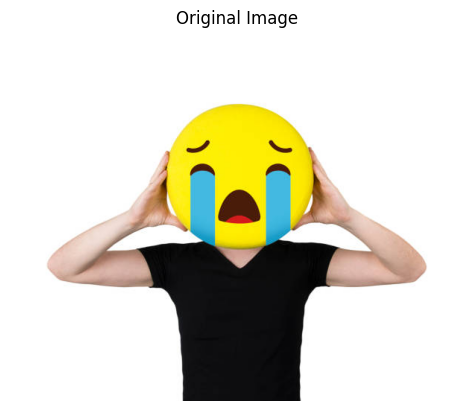

In [4]:
img = cv2.imread('sad_man.jpg')
if img is None:
    raise ValueError("Image not found. Please check the path.")
show_img(img, "Original Image")

### Step 1. Color tracker - yellow

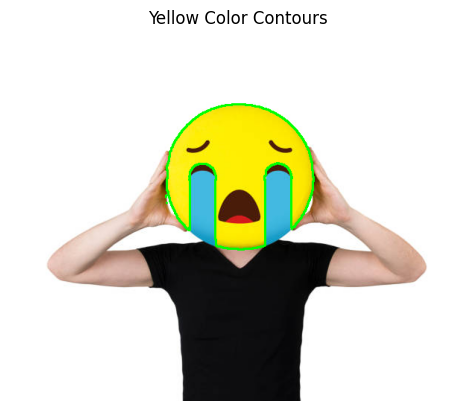

In [5]:
# Step 1. Detect yellow region
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])
mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)
show_img(img_contours, "Yellow Color Contours")

### Step 2. Bound the roi with a box

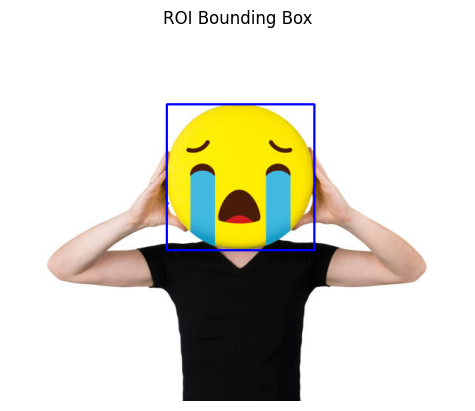

In [6]:
img_blobs = img.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(img_blobs, (x, y), (x + w, y + h), (255, 0, 0), 2)
show_img(img_blobs, "ROI Bounding Box")

### Step 3. Replace crying face with smiley face

In [ ]:
smile = cv2.imread('smiley_emoji.png')  # 請自行確認檔名
if smile is None:
    raise ValueError("笑臉圖片找不到，請確認檔案名稱。")
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    smile_resized = cv2.resize(smile, (w, h))
    img[y:y+h, x:x+w] = smile_resized
show_img(img, "Smiley Face Replaced")


[ WARN:0@0.608] global loadsave.cpp:268 findDecoder imread_('smiley.png'): can't open/read file: check file path/integrity


ValueError: 笑臉圖片找不到，請確認檔案名稱。

# Demo2

In [ ]:
img2 = cv2.imread("cbum.jpg")
if img2 is None:
    raise ValueError("Demo2 圖片找不到")
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Histogram Equalization
equalized = cv2.equalizeHist(gray)

# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Plot all
img_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
eq_rgb = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
clahe_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(15, 5))
titles = ["Original", "Histogram Equalized", "CLAHE Enhanced"]
images = [img_rgb, eq_rgb, clahe_rgb]

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()